# RIR Eval Metrics

Adapted from: https://github.com/schmiph2/pysepm/tree/master

In [ ]:
!pip3 install https://github.com/schmiph2/pysepm/archive/master.zip

In [29]:
from scipy.io import wavfile
import sys
import pysepm
import matplotlib.pyplot as plt
import torchaudio
import librosa
import numpy as np

In [19]:
from google.colab import drive

drive.mount('/content/drive/')
clean_speech_path='/content/drive/MyDrive/XR-Project/307-127535-0021.wav'
reconstructed_speech_path= '/content/drive/MyDrive/XR-Project/307-127535-0021_lr_0.0001_epoch_5000.wav'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [8]:
fs, clean_speech = wavfile.read(clean_speech_path)
fs, reconstructed_speech = wavfile.read(reconstructed_speech_path)

In [26]:
print(f'fwSNRseg: {pysepm.fwSNRseg(clean_speech, reconstructed_speech, fs):.3f}')
print(f'LLR: {pysepm.llr(clean_speech, reconstructed_speech, fs):.3f}')
print(f'CD: {pysepm.cepstrum_distance(clean_speech, reconstructed_speech, fs):.3f}')
print(f'STOI: {pysepm.stoi(clean_speech, reconstructed_speech, fs):.3f}')
print(f'PESQ: {pysepm.pesq(clean_speech, reconstructed_speech, fs)}')
print(f'SRMR: {pysepm.srmr(reconstructed_speech, fs): .3f}')

fwSNRseg: 13.014
LLR: 1.626
CD: 8.144
STOI: 0.957
PESQ: (nan, 1.8605079650878906)
SRMR:  3.993


# RIR Plot

[ 0.50824022  0.33258266  0.01058962 ... -0.01854593 -0.02649708
  0.1122099 ]


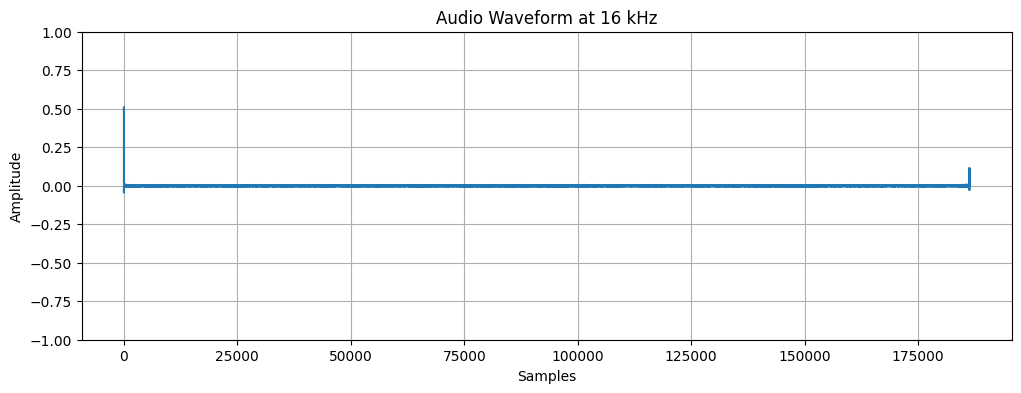

In [31]:

# Load the dereverberated audio (approximation of the original sound)
original_audio, sr = librosa.load(clean_speech_path,sr=16000)

reverberated_audio, sr = librosa.load(reconstructed_speech_path,sr=16000)

# Check lengths and pad the shorter audio
max_length = max(len(original_audio), len(reverberated_audio))
original_audio = np.pad(original_audio, (0, max_length - len(original_audio)), 'constant')
reverberated_audio = np.pad(reverberated_audio, (0, max_length - len(reverberated_audio)), 'constant')


# Compute the FFT of both signals
O = np.fft.fft(original_audio)
R = np.fft.fft(reverberated_audio)

# Perform deconvolution
H = R / O

# Inverse FFT to get the impulse response in the time domain
estimated_rir = np.fft.ifft(H).real

# Regularization parameter
epsilon = 1e-8
H_regularized = R / (O + epsilon)

# Inverse FFT with regularization
estimated_rir_regularized = np.fft.ifft(H_regularized).real
# import pdb
# pdb.set_trace()
print(estimated_rir_regularized)

rir = np.array(estimated_rir_regularized)


# The provided array length is 186368, and the sampling rate is 16 kHz
sampling_rate = 16000  # in Hz

# Let's plot the entire waveform
plt.figure(figsize=(12, 4))
plt.plot(rir)
plt.title('Audio Waveform at 16 kHz')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.ylim(-1,1)
plt.grid(True)
plt.show()

#plt.savefig("/fs/nexus-scratch/pchiniya/XR/purva.png")

#PSNR Plots

In [34]:
#Length check
min_len = min(len(clean_speech), len(reconstructed_speech))
clean_speech = clean_speech[:min_len]
reconstructed_speech = reconstructed_speech[:min_len]

mse = np.mean((clean_speech - reconstructed_speech)**2)
max_pixel = np.max(clean_speech)
psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
print(f'PSNR: {psnr} dB')


PSNR: 58.74019544173025 dB


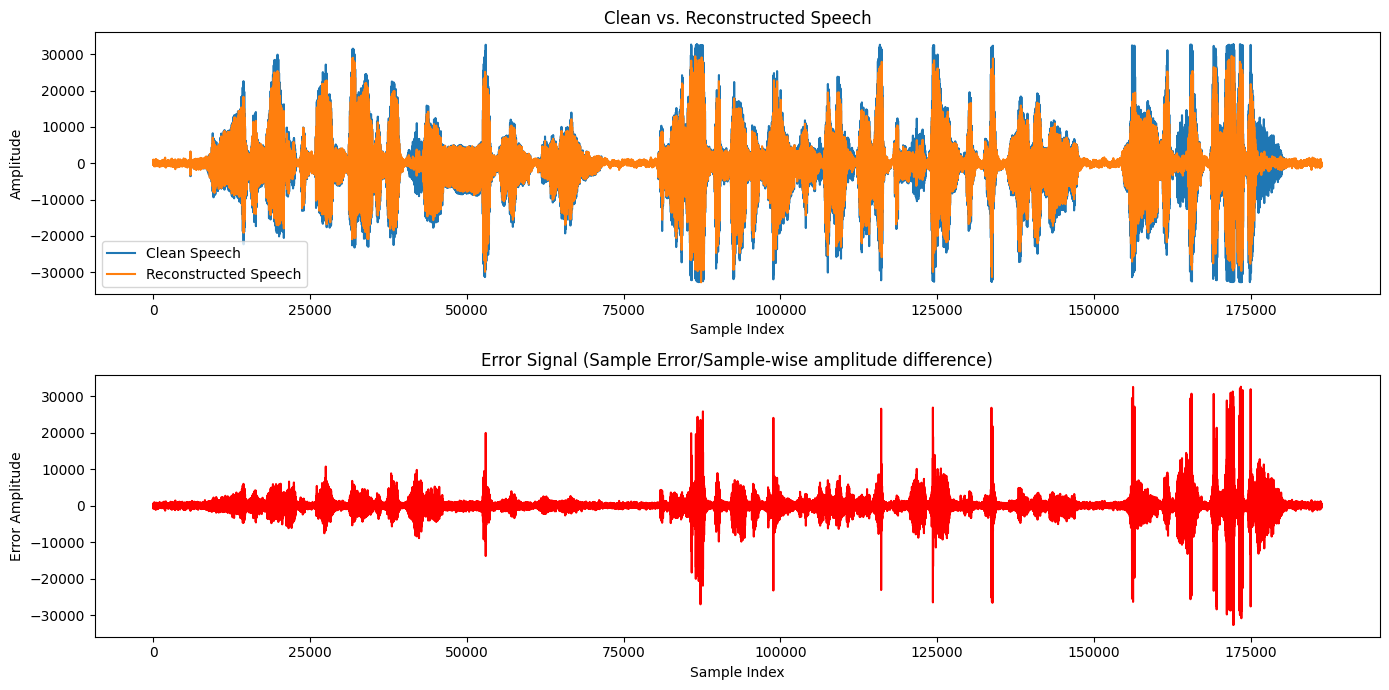

In [37]:
plt.figure(figsize=(14, 7))
# Plot PSNR
plt.subplot(2, 1, 1)
plt.plot(clean_speech, label='Clean Speech')
plt.plot(reconstructed_speech, label='Reconstructed Speech')
plt.title('Clean vs. Reconstructed Speech')
plt.ylabel('Amplitude')
plt.xlabel('Sample Index')
plt.legend()

# Plot Error
plt.subplot(2, 1, 2)
error_signal = clean_speech - reconstructed_speech
plt.plot(error_signal, color='red')
plt.title('Error Signal (Sample Error/Sample-wise amplitude difference)')
plt.xlabel('Sample Index')
plt.ylabel('Error Amplitude')

plt.tight_layout()
plt.show()